<small><i>This notebook was put together by <a href="https://andersy005.github.io/"> Anderson Banihirwe </a> as part of <a href="https://ncar.github.io/PySpark4Climate"> 2017 CISL/SIParCS Research Project </a>: <b>PySpark for Big Atmospheric &amp; Oceanic Data Analysis</b></i></small>

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Objective" data-toc-modified-id="Objective-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objective</a></div><div class="lev1 toc-item"><a href="#Import-packages" data-toc-modified-id="Import-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import packages</a></div><div class="lev1 toc-item"><a href="#Read-USA-shapefile" data-toc-modified-id="Read-USA-shapefile-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read USA shapefile</a></div><div class="lev1 toc-item"><a href="#Load-----GPCP-Version-1.2-One-Degree-Daily-Precipitation-Data-Set-using-spark-xarray-package" data-toc-modified-id="Load-----GPCP-Version-1.2-One-Degree-Daily-Precipitation-Data-Set-using-spark-xarray-package-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load     GPCP Version 1.2 One-Degree Daily Precipitation Data Set using <code>spark-xarray</code> package</a></div><div class="lev1 toc-item"><a href="#Shift-longitude-grid-values" data-toc-modified-id="Shift-longitude-grid-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Shift longitude grid values</a></div><div class="lev1 toc-item"><a href="#Broadcast-the-United-States-shape-to-all-Spark-worker-nodes" data-toc-modified-id="Broadcast-the-United-States-shape-to-all-Spark-worker-nodes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Broadcast the United States shape to all Spark worker nodes</a></div><div class="lev1 toc-item"><a href="#Helper-function-to-mask-out-all-areas-outside-the-United-States-outline" data-toc-modified-id="Helper-function-to-mask-out-all-areas-outside-the-United-States-outline-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Helper function to mask out all areas outside the United States outline</a></div><div class="lev1 toc-item"><a href="#Apply-Spark-Filter-transformation" data-toc-modified-id="Apply-Spark-Filter-transformation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Apply Spark Filter transformation</a></div><div class="lev1 toc-item"><a href="#Collect-filtered-data" data-toc-modified-id="Collect-filtered-data-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Collect filtered data</a></div><div class="lev1 toc-item"><a href="#Concatenate-xarray.Dataset-objects-in-one-dataset-using-xarray-package" data-toc-modified-id="Concatenate-xarray.Dataset-objects-in-one-dataset-using-xarray-package-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Concatenate xarray.Dataset objects in one dataset using <code>xarray</code> package</a></div><div class="lev1 toc-item"><a href="#Visualization" data-toc-modified-id="Visualization-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Visualization</a></div>

# Objective

Demonstrates how to mask an area in your data array using a geographical outline.

This particular example reads a shapefile to get an outline of the United States. You then have the option of masking out all areas inside or outside this outline.

The United States data files for this example can be found on this [page](https://www.ncl.ucar.edu/Applications/Data/#shp).

For experimentation purposes, we will be using [GPCP Version 1.2 One-Degree Daily Precipitation Data Set ds728.3 | DOI: 10.5065/D6D50K46](https://rda.ucar.edu/datasets/ds728.3/index.html#!description). 	
This dataset contains Version 1.2 of the Global Precipitation Climatology Project (GPCP) daily precipitation estimates. The data are daily analyses defined on a global 1.0 degree by 1.0 degree longitude-latitude grid and cover the period October 1996 to (delayed) present.


# Import packages


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 15)
from pyspark.sql import SparkSession
from sparkxarray import reader
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

hv.notebook_extension()

In [2]:
# Create sparksession
spark = SparkSession.builder.appName("usa-shapefile").getOrCreate()
sc = spark.sparkContext

# Read USA shapefile

In [3]:
usa = GeoDataFrame.from_file("/home/abanihi/Documents/climate-data/shapefile/states/")
usa.head()

,CARPOOL,DRVALONE,EMPLOYED,FAMILIES,FEMALE,HOUSHOLD,LAND_KM,MALE,MANUAL,PERSONS,...,SAMP_POP,SERVICE,STATE_ABBR,STATE_FIPS,STATE_NAME,SUB_REGION,UNEMPLOY,WATER_KM,WORKERS,geometry
0,652603.0,3741715.0,5417967.0,2924880.0,5878369.0,4202240.0,143986.610,5552233.0,828906.0,11430602.0,...,1747776.0,1360159.0,IL,17,Illinois,E N Cen,385040.0,1993.335,4199206.0,"POLYGON ((-88.071564 37.51099000000001, -88.08..."
1,36621.0,106694.0,303994.0,122087.0,323930.0,249634.0,159.055,282970.0,22407.0,606900.0,...,72696.0,65498.0,DC,11,District of Columbia,S Atl,23442.0,17.991,229975.0,POLYGON ((-77.00823200000001 38.96655699999999...
2,42968.0,258087.0,335147.0,175867.0,343200.0,247497.0,5062.456,322968.0,44140.0,666168.0,...,102776.0,87973.0,DE,10,Delaware,S Atl,13945.0,1385.022,247566.0,"POLYGON ((-75.70742 38.55747600000001, -75.711..."
3,106918.0,493164.0,671085.0,500259.0,931941.0,688557.0,62384.200,861536.0,124172.0,1793477.0,...,317564.0,205950.0,WV,54,West Virginia,S Atl,71142.0,375.199,661702.0,"POLYGON ((-79.231903 38.48037299999999, -79.27..."
4,376449.0,1732837.0,2481342.0,1245814.0,2462797.0,1748991.0,25316.345,2318671.0,260308.0,4781468.0,...,684773.0,586994.0,MD,24,Maryland,S Atl,111536.0,6188.794,1783061.0,"(POLYGON ((-75.71106 38.649551, -75.70742 38.5..."


CPU times: user 456 ms, sys: 0 ns, total: 456 ms
Wall time: 493 ms


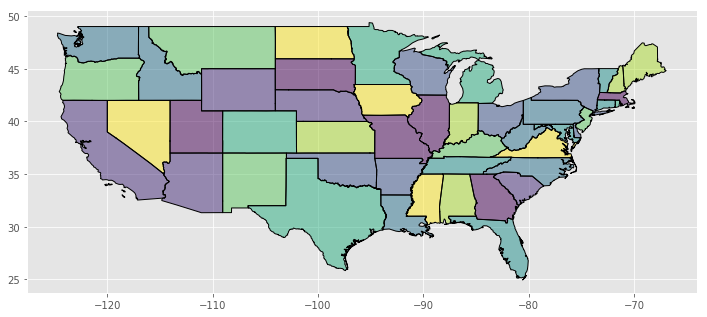

In [4]:
%time usa.plot();

# Load 	GPCP Version 1.2 One-Degree Daily Precipitation Data Set using ```spark-xarray``` package


In [10]:
!ncdump -h /home/abanihi/Documents/climate-data/gpcp_1dd_v1.2_p1d.199610.nc

netcdf gpcp_1dd_v1.2_p1d.199610 {
dimensions:
	lon = 360 ;
	lat = 180 ;
	time = 31 ;

variables:
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
	double time(time) ;
		time:standard_name = "time" ;
		time:long_name = "time (utc)" ;
		time:units = "days since 1996-1-1 0:0:0" ;
		time:calendar = "standard" ;
	float precip(time, lat, lon) ;
		precip:_FillValue = 9.96921e+36f ;
		precip:long_name = "Precipitation estimate from the GPCP one-degree daily data set" ;
		precip:units = "mm/day" ;

// global attributes:
		:Conventions = "CF-1.6" ;
		:title = "GPCP 1DD V1.2 Combined Data Sets" ;
		:technique = "1dd" ;
		:version = "1.2" ;
		:prod_date = "2012-09-18" ;
		:institution = "Mesoscale Atmospheric Processes Laboratory, NASA Goddard Space Flight Center" ;
		:contact = "Mr. D. Smith, NCDC, Rm. 120, 151 Pa

In [11]:
filepath="/home/abanihi/Documents/climate-data/gpcp_1dd_v1.2_p1d.199610.nc"

In [12]:
# Create an RDD (Resilient Distributed Datasets)
rdd = reader.ncread(sc, filepath, partition_on=['lat', 'lon'], partitions=700).cache()

In [13]:
%time rdd.count()

CPU times: user 88 ms, sys: 32 ms, total: 120 ms
Wall time: 50.2 s


64800

In [14]:
rdd.first()

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 31)
Coordinates:
  * lon      (lon) float64 -179.5
  * lat      (lat) float64 -89.5
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
Data variables:
    precip   (time, lat, lon) float64 0.4793 0.3221 0.0 0.4259 1.239 0.4496 ...
Attributes:
    Conventions:           CF-1.6
    title:                 GPCP 1DD V1.2 Combined Data Sets
    technique:             1dd
    version:               1.2
    prod_date:             2012-09-18
    institution:           Mesoscale Atmospheric Processes Laboratory, NASA G...
    contact:               Mr. D. Smith, NCDC, Rm. 120, 151 Patton Ave, Ashvi...
    telephone:             828-271-4053
    facsimile:             828-271-4328
    email:                 dsmith@ncdc.noaa.gov
    url:                   http://precip.gsfc.nasa.gov/
    acknowledgments:       The 1DD data were provided by the NASA/Goddard Spa...
    documentation:         http://rda.ucar.edu/datasets/ds728.

# Shift longitude grid values
- Shift longitudes from range (0-360) to range(-180, 180)

In [15]:
def rdd_idx(dset):
    from shapely.geometry import Point
    lat = dset.lat.values
    lon = dset.lon.values
    if lon >= 180:
        lon = lon - 360
        
    idx = Point(lon, lat)
    return idx, dset

In [16]:
rdd1 = rdd.map(rdd_idx)
rdd1.first()

(<shapely.geometry.point.Point at 0x7fc2781a56d8>, <xarray.Dataset>
 Dimensions:  (lat: 1, lon: 1, time: 31)
 Coordinates:
   * lon      (lon) float64 -179.5
   * lat      (lat) float64 -89.5
   * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
 Data variables:
     precip   (time, lat, lon) float64 0.4793 0.3221 0.0 0.4259 1.239 0.4496 ...
 Attributes:
     Conventions:           CF-1.6
     title:                 GPCP 1DD V1.2 Combined Data Sets
     technique:             1dd
     version:               1.2
     prod_date:             2012-09-18
     institution:           Mesoscale Atmospheric Processes Laboratory, NASA G...
     contact:               Mr. D. Smith, NCDC, Rm. 120, 151 Patton Ave, Ashvi...
     telephone:             828-271-4053
     facsimile:             828-271-4328
     email:                 dsmith@ncdc.noaa.gov
     url:                   http://precip.gsfc.nasa.gov/
     acknowledgments:       The 1DD data were provided by the NASA/Goddar

In [17]:
rdd.unpersist()

PythonRDD[5] at RDD at PythonRDD.scala:48

# Broadcast the United States shape to all Spark worker nodes

In [18]:
usa_shape = sc.broadcast(usa)

# Helper function to mask out all areas outside the United States outline

In [19]:
def point_look_up(element):
    grid_point = element[0]
    dset = element[1]
    
    # Access the broadcasted shape on the worker
    df = usa_shape.value
    
    # See if the grid point is inside the shape
    check = df.contains(grid_point).unique()
    
    if True in check:
        return True
    else:
        return False

# Apply Spark Filter transformation 

In [20]:
rdd2 = rdd1.filter(point_look_up)

In [21]:
%time rdd2.first()

CPU times: user 260 ms, sys: 32 ms, total: 292 ms
Wall time: 1min 31s


(<shapely.geometry.point.Point at 0x7fc2781a56a0>, <xarray.Dataset>
 Dimensions:  (lat: 1, lon: 1, time: 31)
 Coordinates:
   * lon      (lon) float64 -80.5
   * lat      (lat) float64 25.5
   * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
 Data variables:
     precip   (time, lat, lon) float64 5.524 1.945 14.43 8.353 3.731 10.76 ...
 Attributes:
     Conventions:           CF-1.6
     title:                 GPCP 1DD V1.2 Combined Data Sets
     technique:             1dd
     version:               1.2
     prod_date:             2012-09-18
     institution:           Mesoscale Atmospheric Processes Laboratory, NASA G...
     contact:               Mr. D. Smith, NCDC, Rm. 120, 151 Patton Ave, Ashvi...
     telephone:             828-271-4053
     facsimile:             828-271-4328
     email:                 dsmith@ncdc.noaa.gov
     url:                   http://precip.gsfc.nasa.gov/
     acknowledgments:       The 1DD data were provided by the NASA/Goddard Sp

In [22]:
%time rdd2.count()

CPU times: user 92 ms, sys: 28 ms, total: 120 ms
Wall time: 1min 27s


816

# Collect filtered data

In [23]:
%time usa_data = rdd2.collect()

CPU times: user 324 ms, sys: 36 ms, total: 360 ms
Wall time: 1min 28s


In [24]:
data = [item[1] for item in usa_data]

# Concatenate xarray.Dataset objects in one dataset using ```xarray``` package

In [25]:
%time dset = xr.auto_combine(data, concat_dim=None)

CPU times: user 1.94 s, sys: 108 ms, total: 2.05 s
Wall time: 2.06 s


In [26]:
dset

<xarray.Dataset>
Dimensions:  (lat: 24, lon: 57, time: 31)
Coordinates:
  * lat      (lat) float64 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 ...
  * lon      (lon) float64 -123.5 -122.5 -121.5 -120.5 -119.5 -118.5 -117.5 ...
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
Data variables:
    precip   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

# Visualization

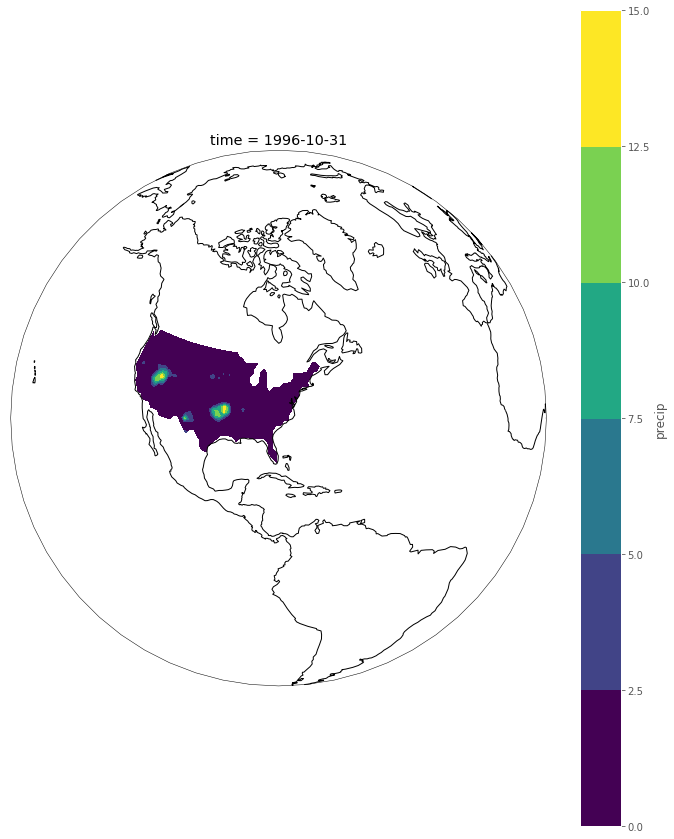

In [27]:
%%opts Image [colorbar=True, fig_size=200] (cmap='viridis')
ax = plt.axes(projection=crs.Orthographic(-80, 35))
dset.precip.isel(time=30).plot.contourf(ax=ax, transform=crs.PlateCarree());
ax.set_global(); ax.coastlines();

:HoloMap   [time]
   :Overlay
      .Image.I     :Image   [lon,lat]   (precip)
      .Coastline.I :Feature   [Longitude,Latitude]
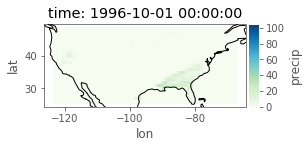
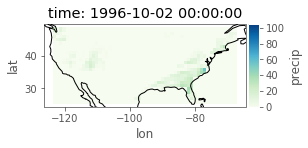
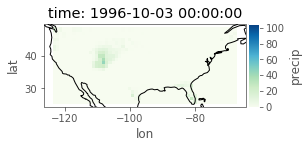
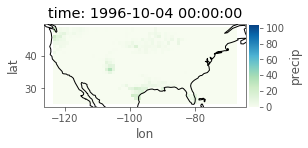
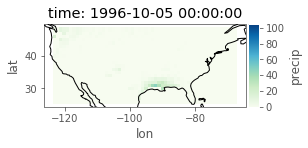
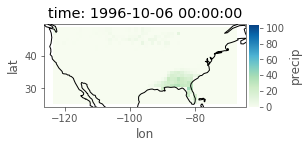
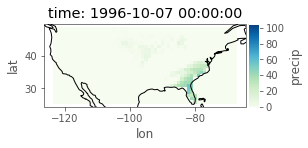
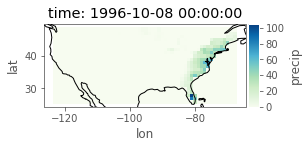
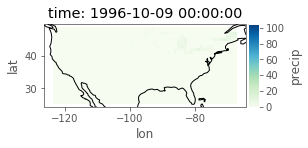
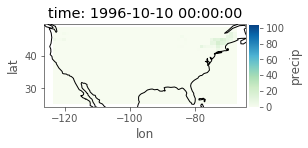
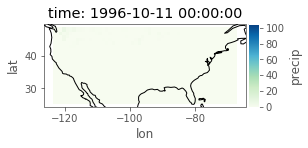
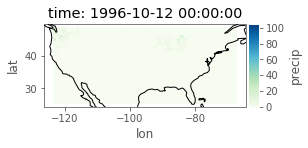
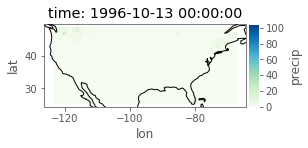
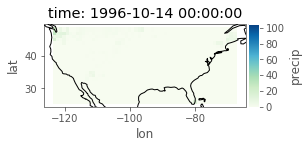
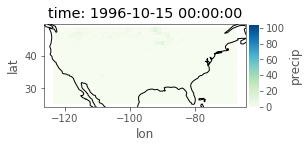
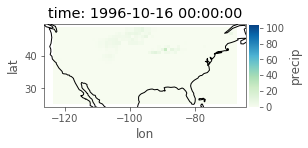
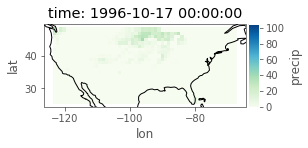
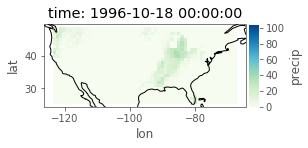
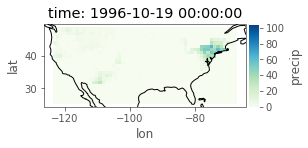
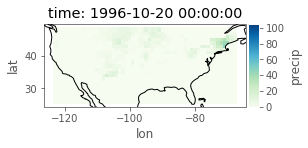
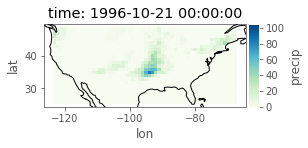
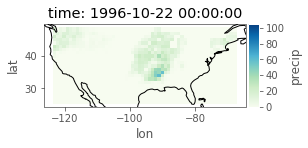
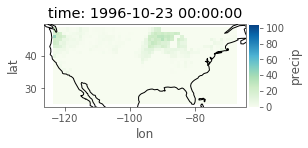
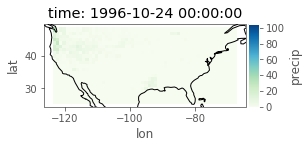
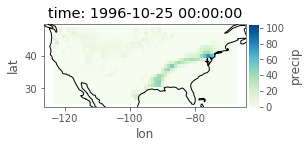
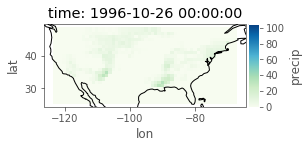
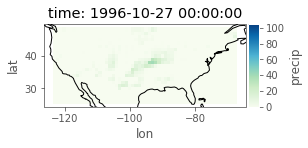
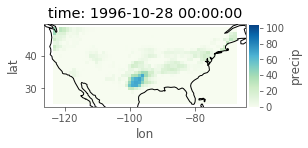
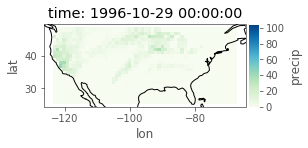
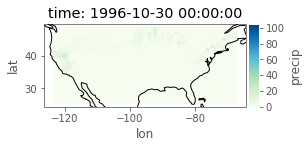
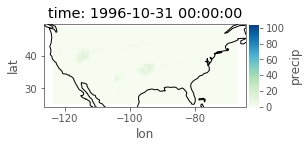

In [28]:
%%opts Image [colorbar=True] (cmap='GnBu')
dataset = gv.Dataset(dset, kdims=['lon', 'lat', 'time'], crs=crs.PlateCarree())
dataset.to(gv.Image, ['lon', 'lat'], ['precip'], ['time']) * gf.coastline()

In [31]:
geo_dims = ['lon', 'lat']

:Layout
   .HoloMap.I   :HoloMap   [time]
      :Overlay
         .FilledContours.I :FilledContours   [lon,lat]   (precip)
         .Coastline.I      :Feature   [Longitude,Latitude]
   .HoloMap.II  :HoloMap   [time]
      :Overlay
         .LineContours.I :LineContours   [lon,lat]   (precip)
         .Coastline.I    :Feature   [Longitude,Latitude]
   .HoloMap.III :HoloMap   [time]
      :Overlay
         .Points.I    :Points   [lon,lat]   (precip)
         .Coastline.I :Feature   [Longitude,Latitude]
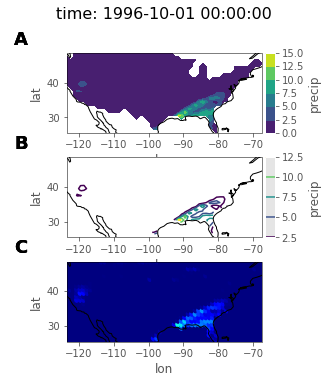
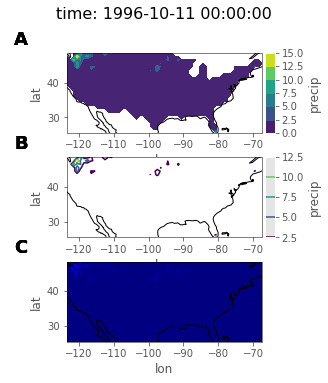
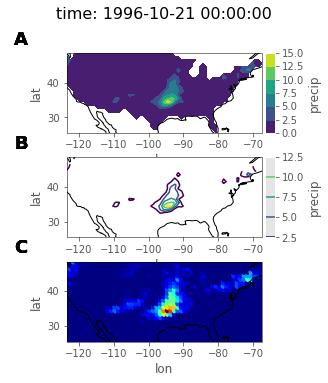
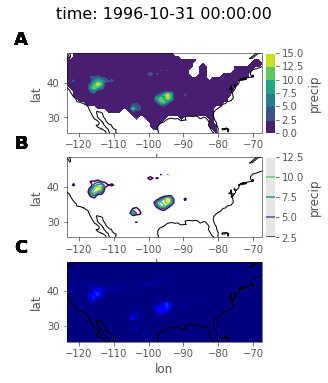

In [32]:
%%opts Points [color_index=2 size_index=None] (cmap='jet')
hv.Layout([dataset.to(el, geo_dims)[::10, ::10] * gf.coastline
           for el in [gv.FilledContours, gv.LineContours, gv.Points]]).cols(1)